In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import itertools
import pickle as pkl
import matplotlib.pyplot as plt
import torch
from args import *
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR


from vision.utils.misc import str2bool, Timer, freeze_net_layers, store_labels
from vision.ssd.ssd import MatchPrior
from vision.ssd.vgg_ssd import create_vgg_ssd
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd
from vision.ssd.mobilenetv1_ssd_lite import create_mobilenetv1_ssd_lite
from vision.ssd.mobilenet_v2_ssd_lite import create_mobilenetv2_ssd_lite
from vision.ssd.squeezenet_ssd_lite import create_squeezenet_ssd_lite
from vision.datasets.voc_dataset import VOCDataset
from vision.datasets.open_images import OpenImagesDataset
from vision.nn.multibox_loss import MultiboxLoss
from vision.ssd.config import vgg_ssd_config
from vision.ssd.config import mobilenetv1_ssd_config
from vision.ssd.config import squeezenet_ssd_config
from vision.ssd.data_preprocessing import TrainAugmentation, TestTransform

## Train

In [2]:
losses = []
def train(loader, net, criterion, optimizer, device, debug_steps=100, epoch=-1):
    net.train(True)
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    for i, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        confidence, locations = net(images)
        regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)  # TODO CHANGE BOXES
        loss = regression_loss + classification_loss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        with open('loss1.pkl','wb') as f:
            pkl.dump(losses, f)
        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
        if i and i % debug_steps == 0:
            avg_loss = running_loss / debug_steps
            avg_reg_loss = running_regression_loss / debug_steps
            avg_clf_loss = running_classification_loss / debug_steps
            print("Epoch : " , epoch , " Iter ", i ," running loss : " , avg_loss )
            running_loss = 0.0
            running_regression_loss = 0.0
            running_classification_loss = 0.0




## Test

In [3]:
def test(loader, net, criterion, device):
    net.eval()
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    num = 0
    for _, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)
        num += 1

        with torch.no_grad():
            confidence, locations = net(images)
            regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)
            loss = regression_loss + classification_loss

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
    return running_loss / num, running_regression_loss / num, running_classification_loss / num




## Implementation

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")
print(DEVICE)

cuda:0


In [5]:

if __name__ == '__main__':
    timer = Timer()

    
    create_net = create_vgg_ssd
    config = vgg_ssd_config
    
        
    train_transform = TrainAugmentation(config.image_size, config.image_mean, config.image_std)
    target_transform = MatchPrior(config.priors, config.center_variance, config.size_variance, 0.5)
    test_transform = TestTransform(config.image_size, config.image_mean, config.image_std)

    
    datasets = []
    for i in range(1) :
        if dataset_type == 'voc':
            dataset = VOCDataset(dataset_path, transform=train_transform,
                                 target_transform=target_transform)
            label_file = os.path.join(checkpoint_folder, "voc-model-labels.txt")
            store_labels(label_file, dataset.class_names)
            num_classes = len(dataset.class_names)
        elif dataset_type == 'open_images':
            dataset = OpenImagesDataset(dataset_path,
                 transform=train_transform, target_transform=target_transform,
                 dataset_type="train", balance_data=balance_data)
            label_file = os.path.join(checkpoint_folder, "open-images-model-labels.txt")
            store_labels(label_file, dataset.class_names)
            
            num_classes = len(dataset.class_names)

        else:
            raise ValueError(f"Dataset type {dataset_type} is not supported.")
        datasets.append(dataset)
    
    train_dataset = ConcatDataset(datasets)
    
    train_loader = DataLoader(train_dataset, batch_size,
                              num_workers=num_workers,
                              shuffle=True)
    if dataset_type == "voc":
        val_dataset = VOCDataset(validation_dataset, transform=test_transform,
                                 target_transform=target_transform, is_test=True)
    elif dataset_type == 'open_images':
        val_dataset = OpenImagesDataset(dataset_path,
                                        transform=test_transform, target_transform=target_transform,
                                        dataset_type="test")
       

    val_loader = DataLoader(val_dataset, batch_size,
                            num_workers=num_workers,
                            shuffle=False)
    net = create_net(num_classes)
    min_loss = -10000.0
    last_epoch = -1

    base_net_lr = base_net_lr if base_net_lr is not None else lr
    extra_layers_lr = extra_layers_lr if extra_layers_lr is not None else lr
    if freeze_base_net:
        freeze_net_layers(net.base_net)
        params = itertools.chain(net.source_layer_add_ons.parameters(), net.extras.parameters(),
                                 net.regression_headers.parameters(), net.classification_headers.parameters())
        params = [
            {'params': itertools.chain(
                net.source_layer_add_ons.parameters(),
                net.extras.parameters()
            ), 'lr': extra_layers_lr},
            {'params': itertools.chain(
                net.regression_headers.parameters(),
                net.classification_headers.parameters()
            )}
        ]
    elif freeze_net:
        freeze_net_layers(net.base_net)
        freeze_net_layers(net.source_layer_add_ons)
        freeze_net_layers(net.extras)
        params = itertools.chain(net.regression_headers.parameters(), net.classification_headers.parameters())
    else:
        params = [
            {'params': net.base_net.parameters(), 'lr': base_net_lr},
            {'params': itertools.chain(
                net.source_layer_add_ons.parameters(),
                net.extras.parameters()
            ), 'lr': extra_layers_lr},
            {'params': itertools.chain(
                net.regression_headers.parameters(),
                net.classification_headers.parameters()
            )}
        ]

    timer.start("Load Model")
    if resume:
        net.load(resume)
    elif base_net:
        net.init_from_base_net(base_net)
    elif pretrained_ssd:
        net.init_from_pretrained_ssd(pretrained_ssd)
    

    net.to(DEVICE)

    criterion = MultiboxLoss(config.priors, iou_threshold=0.5, neg_pos_ratio=3,
                             center_variance=0.1, size_variance=0.2, device=DEVICE)
    optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum,
                                weight_decay=weight_decay)
    

    if scheduler == 'multi-step':
       
        milestones = [int(v.strip()) for v in milestones.split(",")]
        scheduler = MultiStepLR(optimizer, milestones=milestones,
                                                     gamma=0.1, last_epoch=last_epoch)
    elif scheduler == 'cosine':
        
        scheduler = CosineAnnealingLR(optimizer, t_max, last_epoch=last_epoch)
    else:
        
        parser.print_help(sys.stderr)
        sys.exit(1)

   

    
    for epoch in range(last_epoch + 1, num_epochs):
        scheduler.step()
        train(train_loader, net, criterion, optimizer,
              device=DEVICE, debug_steps=debug_steps, epoch=epoch)
        
        if epoch % validation_epochs == 0 or epoch == num_epochs - 1:
            val_loss, val_regression_loss, val_classification_loss = test(val_loader, net, criterion, DEVICE)
           
            model_path = os.path.join(checkpoint_folder, f"{arg_net}-Epoch-{epoch}-Loss-{val_loss}.pth")
            net.save(model_path)
            

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch :  0  Iter  10  running loss :  32.4276460647583
Epoch :  0  Iter  20  running loss :  25.30503616333008
Epoch :  0  Iter  30  running loss :  21.92191925048828
Epoch :  0  Iter  40  running loss :  20.187278175354002
Epoch :  0  Iter  50  running loss :  18.734716415405273
Epoch :  0  Iter  60  running loss :  17.494582176208496
Epoch :  0  Iter  70  running loss :  16.026711177825927
Epoch :  0  Iter  80  running loss :  14.888213634490967
Epoch :  0  Iter  90  running loss :  13.8558988571167
Epoch :  0  Iter  100  running loss :  13.331711769104004
Epoch :  0  Iter  110  running loss :  12.053973197937012
Epoch :  0  Iter  120  running loss :  11.575276947021484
Epoch :  0  Iter  130  running loss :  10.844783782958984
Epoch :  0  Iter  140  running loss :  10.469704627990723
Epoch :  0  Iter  150  running loss :  9.59404535293579
Epoch :  0  Iter  160  running loss :  9.718985557556152
Epoch :  0  Iter  170  running loss :  9.069118309020997
Epoch :  0  Iter  180  running lo

KeyboardInterrupt: 

In [6]:
with open('loss1.pkl','rb') as f:
               x =  pkl.load(f)

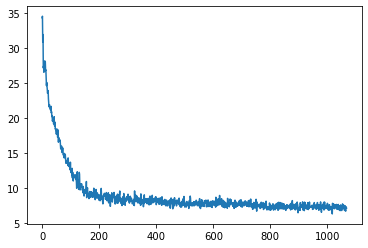

In [7]:
import numpy as np
y = np.arange(0,len(x),1)
fig = plt.figure()
plt.plot(y,x)
plt.show()

In [ ]:
print()